In [ ]:
# 2019A 1)结果

In [13]:
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def rho(p):
    return (0.85 * p - 85.0) / (1.0 / (np.exp(90100664/13926267 + 3367307*p/501847788) - 1.0) - p + 1005.6) + 0.85

# bisect for p, p should be in range of [1, 200]
@lru_cache(maxsize=None)
def p(rho_p, eps=1e-10):
    p_low = 0
    p_high = 200.0
    while True:
        p_mid = (p_low + p_high) / 2.0
        # print("Trying:", p_mid)
        rho_mid = rho(p_mid)
        if abs(p_mid - p_low) < eps or abs(p_mid - p_high) < eps:
            raise Exception("p not found")
        if abs(rho_mid - rho_p) < eps:
            return p_mid
        elif rho_mid < rho_p:
            p_low = p_mid
        else:
            p_high = p_mid

In [14]:
rho(150)

0.8996727113747187

In [15]:
p(0.8996724971110621)

149.99979622662067

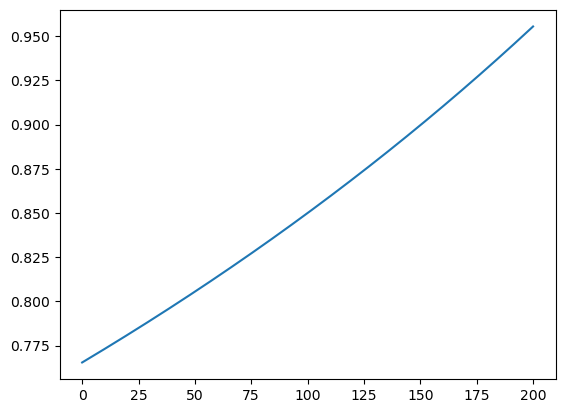

In [16]:
# plot rho(p)
import matplotlib.pyplot as plt
p_list = np.linspace(0, 200, 1000)
rho_list = [rho(p) for p in p_list]
plt.plot(p_list, rho_list)

In [17]:
from math import pi
C = 0.85
A = pi * (1.4 / 2) ** 2
V = 500 * pi * (10 / 2) ** 2
C_A_SQRT2_OVER_V = C * A * np.sqrt(2) / V
OVER_V = 1 / V

In [18]:
T = 10e4 # in millisecond
dt = 1e-1 # in millisecond
N = int(T / dt)
# in millisecond
open_rest_interval = 10

In [19]:
def cal(open_in_interval):
    rho_by_t = np.zeros(N)
    rho_by_t.fill(0.85)
    for t_ in range(1, N):
        # rhon -> rhon+1
        # t_ -> t_ + 1
        # print(rho_by_t[t_ - 1])
        # if t_ % (N // 5) == 0:
        #     print(t_ / N)
        open_in = False
        open_out = False
        # in millisecond
        t = t_ * dt
        if t % (open_in_interval + open_rest_interval) < open_in_interval:
            open_in = True
        if t % 100 < 2.4:
            open_out = True
        dif = 0.0
        if open_in:
            dif += C_A_SQRT2_OVER_V * np.sqrt((160 - p(rho_by_t[t_ - 1])) * rho(160))
        if open_out:
            t_mod = t % 100
            if t_mod < 0.2:
                dif -= OVER_V * rho_by_t[t_ - 1] * 100 * t_mod
            elif 0.2 <= t_mod < 2.2:
                dif -= OVER_V * rho_by_t[t_ - 1] * 20
            else:
                dif -= OVER_V * rho_by_t[t_ - 1] * (20 - 100 * (t_mod - 2.2))
        rho_by_t[t_] = rho_by_t[t_ - 1] + dif * dt
    return rho_by_t

In [20]:
rho_by_t = cal(0.3)
rho_by_t

array([0.85      , 0.85001318, 0.85000471, ..., 0.85644365, 0.85644365,
       0.85644365])

In [21]:
rho(150)

0.8996727113747187

In [22]:
min_loss = 1e10
best = None
# best must be within [0.27, 0.29]
# gradient descent for the best value

# Define the loss function
def loss(open_in_interval):
    rho_by_t = cal(open_in_interval)
    kernel = np.ones(10000) / 10000
    rho_smooth = np.convolve(rho_by_t, kernel, mode='same')
    # return np.sum(np.abs(rho_smooth[3 * N // 5 : N - N // 100] - rho(100)))
    return np.sum(np.abs(rho_smooth[3 * N // 5 : N - N // 100] - rho(150)))

# Define the gradient of the loss function
def gradient(open_in_interval):
    eps = 1e-4
    return (loss(open_in_interval + eps) - loss(open_in_interval - eps)) / (2 * eps)

# Initialize the value of open_in_interval
open_in_interval = 0.7629654403773574

# Set the learning rate and number of iterations
learning_rate = 1e-10
num_iterations = 0

min_loss = loss(open_in_interval)
best = open_in_interval

# Perform gradient descent
for i in range(num_iterations):
    grad = gradient(open_in_interval)
    open_in_interval -= learning_rate * grad
    print(f"Done {(i / num_iterations) * 100}%: open_in_interval = {open_in_interval}, loss = {loss(open_in_interval)}")
    if loss(open_in_interval) < min_loss:
        min_loss = loss(open_in_interval)
        best = open_in_interval


# for open_in_interval in np.linspace(0.280, 0.289, 100):
#     if open_in_interval % 0.01 == 0:
#         print(open_in_interval)
#     rho_by_t = cal(open_in_interval)
#     kernel = np.ones(1000) / 1000
#     rho_smooth = np.convolve(rho_by_t, kernel, mode='same')
#     loss = np.sum(np.abs(rho_smooth[N // 20 : N // 10] - 0.85))
#     if loss < min_loss:
#         min_loss = loss
#         best = open_in_interval
print(best, min_loss)

0.7629654403773574 0.0824907295132592


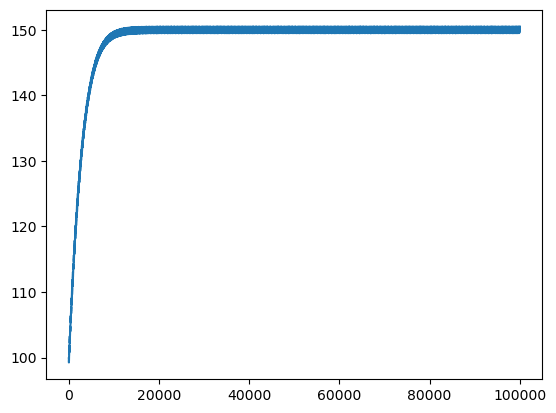

In [23]:
# plot p(t) with best open_in_interval
ans = best
rho_by_t = cal(ans)
p_by_t = [p(rho_) for rho_ in rho_by_t]
plt.plot(np.linspace(0, T, N), p_by_t)

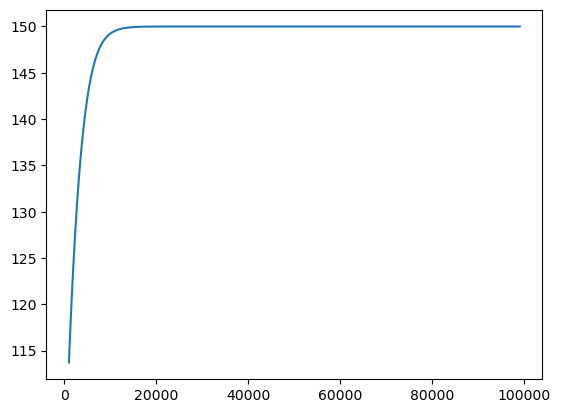

In [24]:
p_smooth = p_by_t
kernel = np.ones(10000) / 10000
p_smooth = np.convolve(p_by_t, kernel, mode='same')
# remove the head and tail because they are not smooth
start = N // 100
end = N - N // 100
p_smooth = p_smooth[start :end]
plt.plot(np.linspace(0, T, N)[start : end], p_smooth)